# TwitterGroups
The goal of this project is to group Twitter users based on the similarity of their tweets. Applications of doing this could be to generate similar users for someone to follow, or to develop topic groups which certain users belong to, which could then allow someone to explore what users talk about these particular topics.

The structure of the project is split into three parts: Collection, Preprocessing, and Modeling. 
At a high level, 
These phases are described in detail in the following sections.


# Collection
This phase is concerned with collecting data from Twitter. For this project, I decided to collect 1000 Tweets from each of my friends (those whom I follow). This should provide a fairly varied group of users, and a large enough sample from each user so as to determine latent topics, while still being small enough that it is computationally feasible using a single machine, and can be collected in a reasonable amount of time given the rate limiting that Twitter enforces on its API calls.    

To facilitate this, Tweepy is used as a convenient wrapper to make the API calls, and a MongoDB store is used to store the users and tweets. This is simple to do as calls to the Twitter API return JSON, and MongoDB stores JSON.

The following code efficiently gets and stores the user information by first collecting the ids of all friends, 
and then retrieving their JSON objects 100 at a time using the ids. The ids are pickled for later when the tweets for each user are retrieved. Finally, each user is inserted into the database. 

In [11]:
import config
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import Normalizer 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.pipeline import make_pipeline
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.util import ngrams
from nltk.stem.porter import PorterStemmer
import string
from pymongo import MongoClient
from time import time
import Stemmer
import tweepy
from tweepy.parsers import RawParser
import json

In [ ]:
auth = tweepy.OAuthHandler(config.consumer_key, config.consumer_secret)
auth.set_access_token(config.access_token, config.access_token_secret)
api = tweepy.API(auth)
raw_api = tweepy.API(auth, parser=RawParser())

# get mongo store
mongo_collection = config.get_mongo_collection()

ids = []
for page in tweepy.Cursor(api.friends_ids, count=200).pages():
    ids.extend(page)

ids.append(435495696) # add myself :) 

# get the json objects, can do 100 ids at a time
friends = []
for i in range(100, len(ids)+100, 100):
    batch = json.loads(raw_api.lookup_users(user_ids=ids[i-100:i]))
    friends.extend(batch)

for user in friends:
    user['tweets'] = []
    user['_id'] = user['id_str']
    del user['id_str']
    mongo_collection.insert_one(user)

the next section of code populates the tweets of each user, sleeping in the event that the rate limit is reached 

In [ ]:
for i, id in enumerate(ids):
    print("Progress: %d/%d" % (i+1,len(ids)))
    try:
        for page in tweepy.Cursor(api.user_timeline, count=200, id=id).pages(5):
            statusus  = []
            for status in page:
                statuses.append(status._json)
            collection.update({'_id':str(id)}, {'$push': {'tweets': { '$each': statuses}}})
    except tweepy.TweepError:
        print("RateLimited: Sleeping for 15 minutes")
        time.sleep(6 * 15)

# Preprocessing
In this next phase, the tweets of each user must be processed into a usable form. This involves cleaning each tweet by removing the mentions (@'s), the # symbol, links, and only keeping words that have a length greater than 2. I also concatenate each users tweets into a single text, as this will allow me to build up a representative body of text over all of the users tweets which I have collected

In [16]:
mongo_collection = config.get_mongo_collection()

users = mongo_collection.find({'statuses_count': {'$gt': 150}}, 
                              {'tweets':1, 'statuses_count':1, 'screen_name':1, '_id':1})

english_stemmer = Stemmer.Stemmer('en')
stopset = set(stopwords.words('english') + list(string.punctuation) + 
    ['fucking', 'fuck', 'shit', 'amp', 'renato', 'nigga', 'niggas', 'ass', 'omg', 
     'lol','bitch', 'bro', 'lmao', 'haha', 'hahaha']) 
# remove words which add no meaning, might be a good idea to just remove expletives completely

def clean_text(text):
    """preprocess text by removing all mentions, emojis, links and changing the text to lower case"""
    
    # thanks to J.F. Sebastian from 
    # http://stackoverflow.com/questions/33404752/removing-emojis-from-a-string-in-python
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)
    mention_pattern = re.compile(r"@[^\s]+")
    url_pattern = re.compile(r"http\S+")
    
    patterns = [emoji_pattern, mention_pattern, url_pattern]
    for p in patterns:
        text  = p.sub(r"", text)
    cleaned_text = text.lower()
    return cleaned_text

def combine_tweets(tweets):
    combined = ""
    for tweet in tweets:
        text = tweet['text']
        cleaned = clean_text(text)
        combined += cleaned + " "
    tokens = nltk.word_tokenize(combined)
    combined = " ".join(list(filter(lambda x: len(x) > 2 and x.isalpha(), tokens)))
    return combined

class StemmedTfidfVectorizer(TfidfVectorizer):
    def build_analyzer(self):
        analyzer = super(TfidfVectorizer, self).build_analyzer()
        return lambda doc: english_stemmer.stemWords(analyzer(doc))

In [17]:
print("Combining and cleaning tweets")
t0 = time()
user_documents = {}
for user in users:
    tweets = user['tweets']
    user_documents[user['screen_name']] = combine_tweets(tweets)
print("Done in {:0.3f}s".format(time()-t0))

Combining and cleaning tweets
Done in 56.615s


# Modeling
For the modeling phase, I will first convert each user's concatenated tweets into a tf-idf matrix, which will allow us to better represent how important each word is to a particular user. Following this, I will run SVD on the tf-idf matrix in order to map the terms into a latent semantic space. In other words, we want to determine topic groups based on terms in the tf-idf matrix, and how much each user is associated with these groups. Finally, I use K-means to cluster these users, and can then map it back up the pipeline to group the users themselves

# TF-IDF
Here I make the tfidf matrix with unigrams, bigrams, and trigrams, and set the min/max df params to make sure that only significant words are used in the next steps 

In [48]:
print("Transforming Corpora into tf-idf matrix")
t0 = time()
tfidf = TfidfVectorizer(max_df=.8, min_df=.2, stop_words=stopset, ngram_range=(1,3), use_idf=True)
all_user_docs = list(user_documents.values())
X = tfidf.fit_transform(all_user_docs)
print("Done in {:0.3f}s".format(time()-t0))

Transforming Corpora into tf-idf matrix
Done in 14.453s


# LSA
Here I run SVD on the tf-idf matrix in order to map the corpora into a lower dimensional semantic space. This will be particularly useful for K-means, which performs much better in lower dimensions since it employs euclidean distance measures in it's objective function. It's also important to note that I need to re-standardize here, as SVD does not do this for us 

In [49]:
print("Running LSA on tf-idf")
t0 = time()
svd = TruncatedSVD(n_components=70)
normalizer = Normalizer(copy=False)
lsa = make_pipeline(svd, normalizer)
X_lsa = lsa.fit_transform(X)
print("Done in {:0.3f}s".format(time()-t0))

print("Variance explained by LSA components: {}%"
    .format(int(svd.explained_variance_ratio_.sum() * 100)))

Running LSA on tf-idf
Done in 0.246s
Variance explained by LSA components: 57%


# K-Means
K-Means is a clustering algorithm in the same vein as KNN which tries to cluster vectors (training examples) based on minimizing the __within cluster sum of squares__. In other words, it tries to place examples into clusters based on canonical 'centroids' which serve as the center for these groups. Examples are placed into the cluster for which the centroid is closest. Intuitively, this should result in clusters for which we have the most similar examples grouped together.

There are a couple disadvantages to this approach. One: the number of clusters K must be specified beforehand; Two: k-means only allows a single example to belong to a single cluster, but for data such as we have here, a single Twitter user might Tweet about a large variety of subjects.

Another approach I might look into is fuzzy c-means clustering.

Below I use the so called 'elbow-method' to try and find a good number of clusters to use for the k-means algorithm. It is easy to see large drops in distortion (how dispersed the clusters are) from 0-5 and it slowly declines afterwards; based on some experimentation I have found that for my particular data, a k of about 10 yields good results.

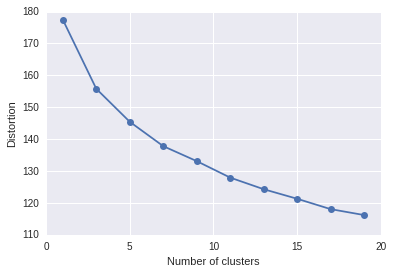

In [50]:
%matplotlib inline 
min_k = 1
max_k = 20
by=2
distortions = []
for i in range(min_k, max_k, by):
    km = KMeans(n_clusters=i, init='k-means++', max_iter=300, random_state=0)
    km.fit(X_lsa)
    distortions.append(km.inertia_)
plt.plot(range(min_k, max_k, by), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

In [51]:
k = 10
km = KMeans(n_clusters=k, init='k-means++', n_init=1, max_iter=100, random_state=0)
km.fit(X_lsa)
clusters = km.labels_.tolist()
y_km = km.fit_predict(X_lsa)

In [52]:
print("Top terms per cluster:")
original_space_centroids = svd.inverse_transform(km.cluster_centers_)
order_centroids = original_space_centroids.argsort()[:, ::-1]

terms = tfidf.get_feature_names()
for i in range(k):
    print("Cluster %d:" % i, end='')
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind], end='')
    print()

Top terms per cluster:
Cluster 0: rockets nba curry houston team james basketball season texans player
Cluster 1: science photo via space youtube earth awesome join latest follow
Cluster 2: damn dude dont smoke dick hell hoe weed fuckin dad
Cluster 3: happy birthday seriously cute oomf damn literally okay bae text bed
Cluster 4: learning deep machine data research article science computer paper google
Cluster 5: creek texas happy birthday soccer college clear team football senior state
Cluster 6: texans houston football team appreciate nfl season fans baseball congrats
Cluster 7: data learning science machine code via using computer language library
Cluster 8: trump debate donald hillary texas donald trump election clinton women vote
Cluster 9: college dog literally cute texas houston austin semester cause happy birthday


In [53]:
from sklearn.manifold import MDS
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd

dist = 1 - cosine_similarity(X_lsa)
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)
pos = mds.fit_transform(dist)
xs, ys = pos[:, 0], pos[:, 1]

df = pd.DataFrame(dict(x=xs,y=ys,label=clusters,user=list(user_documents.keys())))

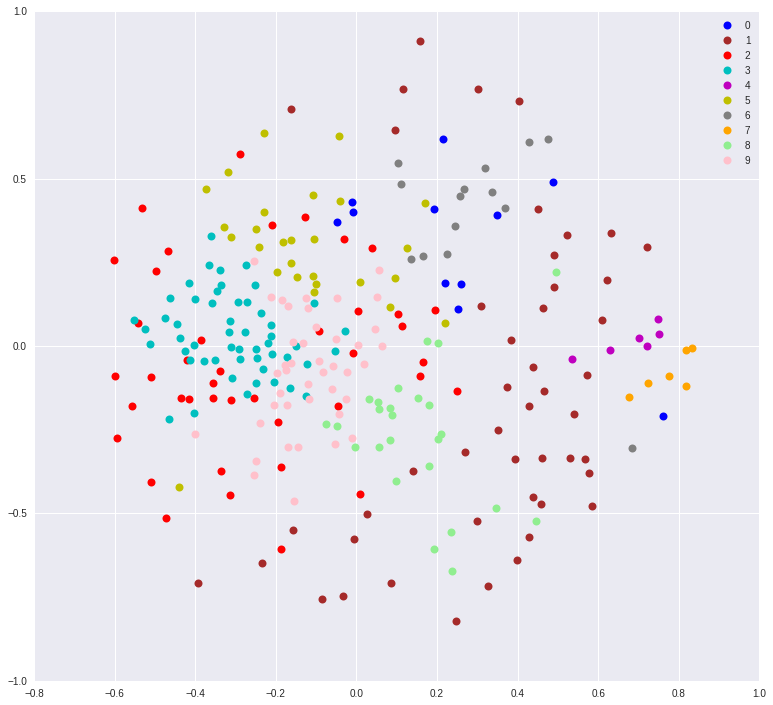

In [54]:
%matplotlib inline
colors = ['b', 'Brown', 'r', 'c', 'm', 'y', 
          'Gray', 'Orange', 'LightGreen', 
          'Pink', 'g', 'Goldenrod',
          'Black', 'Khaki', 'Salmon', '#D7BDE2']

groups = df.groupby('label')

fig,ax = plt.subplots(figsize=(13,12))

for name,group in groups:
    ax.plot(group.x, group.y, c=colors[name], ms=8, linestyle='', marker='o', label=group.label.iloc[0])
plt.legend()

In [55]:
for name,group in groups:
    print(name,list(group.user))
    print()

0 ['thejohancheah', 'CraigCanepa', 'daltonfarine', 'BDdonaldV', 'TyPantermuehl', 'AmirSaeed10', 'ceejay_green25', 'HoustonRockets', 'itzdenmark', 'SportsOnIine', 'MGorek2']

1 ['google', 'GoogleFacts', 'antoniosmith94', 'UTAustin', 'HilaKleinH3', 'sxsw', 'railstutorial', 'pythoncoders', 'neiltyson', 'alexisholseth', 'ActionBronson', 'elonmusk', 'h3h3productions', 'azizansari', 'EaterAustin', 'morgan_e_stg', 'twitter', 'TwitrCovers', 'ZooeyDeschanel', 'ScienceAllDay', 'RachelSasiene', 'WhiteHouse', 'MellowAustin', 'NASA', 'thejedii_', '12TaylorCOS', 'smoothiekinglc_', 'alispagnola', 'RickandMorty', 'BillGates', 'YouTube', 'chancetherapper', 'ThePSF', 'instagram', 'MacMiller', 'BillNye', 'CallieRossi', 'MarsCuriosity', 'asherroth', 'TeamYouTube', 'jimmyfallon', 'kanyewest', 'stillblazingtho', 'iamjohnoliver', 'Drake', 'TechCrunch', 'NatGeo']

2 ['grantwakeboard', 'matlock_caleb', 'John_M2321', 'maddymo6', 'AntiJokeCat', 'ForYourlnfo', 'Salam_Lawal', 'ray_renato', 'Hassaan911', 'Sethrogen

In [56]:
print(len(list(user_documents.keys())))

271


In [2]:
from matplotlib.pyplot import figure, show
import numpy as npy
from numpy.random import rand


if 1: # picking on a scatter plot (matplotlib.collections.RegularPolyCollection)

    x, y, c, s = rand(4, 100)
    def onpick3(event):
        ind = event.ind
        print('onpick3 scatter:', ind, npy.take(x, ind), npy.take(y, ind))

    fig = figure()
    ax1 = fig.add_subplot(111)
    col = ax1.scatter(x, y, 100*s, c, picker=True)
    #fig.savefig('pscoll.eps')
    fig.canvas.mpl_connect('pick_event', onpick3)

show()

onpick3 scatter: [68 79] [ 0.27010084  0.27593797] [ 0.86314401  0.88932873]
onpick3 scatter: [66] [ 0.16777341] [ 0.43057109]
onpick3 scatter: [3] [ 0.14716211] [ 0.40059971]
onpick3 scatter: [80] [ 0.13090237] [ 0.26863167]
onpick3 scatter: [35] [ 0.06929188] [ 0.2221843]
onpick3 scatter: [39] [ 0.03418791] [ 0.30126076]
